<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/other_courses/Coursework_analytics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)


## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

### 1.1. Подготовка к работе с базой данных.

In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#conn = 0
def open_connection():
    """
    Подключаемся к базе данных. 
    В случае ошибки SQL запроса соединение разрывается, поэтому этой функцией удобно переподключаться.
    """
    
    global conn
    pg_connection = {
        "host": "dsstudents.skillbox.ru",
        "port": 5432,
        "dbname": "human_resources",
        "user": "readonly",
        "password": "6hajV34RTQfmxhS"
        }
    conn = psycopg2.connect(**pg_connection)
    #cursor = conn.cursor()

def close_connection():
    """
    Для отключения от базы в конце блока расчетов.
    """
    
    conn.close()

def get_column_names(curs):
    """
    Промежуточная функция для определения имен столбцов в результатах SQL запроса с сервера.
    Используется для формирования датафрейма.
    """
    
    table_columns = []
    try:
        table_columns = [col.name for col in curs.description]
        return table_columns
    except Exception as exc:
        print('ошибка при получении названий столбцов: ', exc)
        pass
    return table_columns

def postgresql_to_dataframe(select_query):
    """
    Функция конвертирует результат запроса в датафрейм.
    Возвращает датафрейм.
    """
    
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    col_names = get_column_names(cursor)
    tupples = cursor.fetchall()
    df = pd.DataFrame(tupples, columns=col_names)
    cursor.close()
    
    return df

In [ ]:
open_connection()

# проверям наличие нужных нам таблиц
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"
postgresql_to_dataframe(sql_str).iloc[[0,1,4,8]]

,table_name
0,hr_dataset
1,production_staff
4,recruiting_costs
8,salary_grid


### 1.2. Анализ `hr_dataset`.

In [ ]:
#выводим столбцы таблицы отдельно, так как все они не помещаются по ширине при выводе в dataframe
sql_str = """
SELECT 
    table_name, 
    column_name, 
    data_type
FROM 
    information_schema.columns
WHERE 
    table_name = 'hr_dataset';
"""
postgresql_to_dataframe(sql_str)   

,table_name,column_name,data_type
0,hr_dataset,id,integer
1,hr_dataset,Employee Name,character varying
2,hr_dataset,Employee Number,integer
3,hr_dataset,marriedid,integer
4,hr_dataset,maritalstatusid,integer
5,hr_dataset,genderid,integer
6,hr_dataset,empstatus_id,integer
7,hr_dataset,deptid,integer
8,hr_dataset,perf_scoreid,integer
9,hr_dataset,age,integer


In [ ]:
sql_str = """
SELECT * FROM hr_dataset;
"""
df = postgresql_to_dataframe(sql_str)
df

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,306,"Navathe, Kurt",1009919960,0,0,1,1,3,3,48,...,2017-02-10,289,None,N/A - still employed,Active,IT/IS,Senior BI Developer,Brian Champaigne,Indeed,Fully Meets
306,307,"Wang, Charlie",1009919970,0,0,1,1,3,3,36,...,2017-02-15,284,None,N/A - still employed,Active,IT/IS,Senior BI Developer,Brian Champaigne,Indeed,Fully Meets
307,308,"Smith, Jason",1009919980,0,0,1,1,3,3,34,...,2017-02-15,284,None,N/A - still employed,Active,IT/IS,BI Developer,Brian Champaigne,Indeed,Fully Meets
308,309,"Westinghouse, Matthew",1009919990,1,1,1,1,3,3,30,...,2017-04-20,220,None,N/A - still employed,Active,IT/IS,BI Developer,Brian Champaigne,Indeed,Fully Meets


**Пол, Семейное положение, Возраст по подразделениям и в компании в целом**

In [ ]:
sql_str = """
SELECT department, count(id), avg(genderid) as Gender, avg(marriedid) as Married, avg(age) as age
FROM hr_dataset 
WHERE hr_dataset."Employment Status" = 'Active'
GROUP BY department
UNION ALL
SELECT 'Company Total' as department, count(id), avg(genderid) as Gender, avg(marriedid) as Married, avg(age) as age
FROM hr_dataset WHERE hr_dataset."Employment Status" = 'Active';
"""
df = postgresql_to_dataframe(sql_str)
total_employees = int(df['count'][6])
print('gender: 1(M)/0(F), married: 1(Y)/0(N)')
df

gender: 1(M)/0(F), married: 1(Y)/0(N)


,department,count,gender,married,age
0,Production,106,0.41509433962264150943,0.33018867924528301887,38.5000000000000000
1,Admin Offices,8,0.37500000000000000000,0.62500000000000000000,32.5000000000000000
2,IT/IS,35,0.54285714285714285714,0.42857142857142857143,37.4000000000000000
3,Executive Office,1,0E-20,1.00000000000000000000,63.0000000000000000
4,Software Engineering,7,0.28571428571428571429,0.14285714285714285714,36.4285714285714286
5,Sales,26,0.53846153846153846154,0.30769230769230769231,38.5384615384615385
6,Company Total,183,0.44808743169398907104,0.35519125683060109290,38.0874316939890710


**Текучка кадров по подразделениям компании**

In [ ]:
sql_str = """
SELECT department, count_active, count_total,
round((count_total-count_active)*100/count_active) as turnover_percent
FROM
(SELECT department, 
COUNT(id) filter (where hr_dataset."Employment Status" = 'Active') as count_active,
COUNT(id) as count_total
FROM hr_dataset
GROUP BY department) as t;
"""
postgresql_to_dataframe(sql_str)

,department,count_active,count_total,turnover_percent
0,Production,106,208,96.0
1,Admin Offices,8,10,25.0
2,IT/IS,35,50,42.0
3,Executive Office,1,1,0.0
4,Software Engineering,7,10,42.0
5,Sales,26,31,19.0


**Текучка кадров по расовой принадлежности в целом по компании**

In [ ]:
sql_str = """
SELECT racedesc, active, total,
round((total-active)*100/active) as turnover_percent
FROM
(SELECT racedesc, 
COUNT(id) filter (where hr_dataset."Employment Status" = 'Active') as active,
COUNT(id) as total
FROM hr_dataset
GROUP BY racedesc) as t;
"""
postgresql_to_dataframe(sql_str)

,racedesc,active,total,turnover_percent
0,American Indian or Alaska Native,3,4,33.0
1,Hispanic,2,4,100.0
2,Two or more races,9,18,100.0
3,Asian,18,34,88.0
4,White,115,193,67.0
5,Black or African American,36,57,58.0


**Количество сотрудников по расам в каждом департаменте и в компании в целом**

In [ ]:
sql_str = f"""
SELECT department, 
COUNT(id) filter (where racedesc = 'American Indian or Alaska Native') as native_americian,
COUNT(id) filter (where racedesc = 'Hispanic') as hispanic,
COUNT(id) filter (where racedesc = 'Two or more races') as multi_race,
COUNT(id) filter (where racedesc = 'Asian') as asian,
COUNT(id) filter (where racedesc = 'White') as white,
COUNT(id) filter (where racedesc = 'Black or African American') as black,
COUNT(id) as department_Total
FROM hr_dataset
WHERE hr_dataset."Employment Status" = 'Active'
GROUP BY department
UNION ALL
SELECT 'Company Total, %' as department,
round(COUNT(id) filter (where racedesc = 'American Indian or Alaska Native')*100.0/{total_employees}) as native_americian,
round(COUNT(id) filter (where racedesc = 'Hispanic')*100.0/{total_employees}) as hispanic,
round(COUNT(id) filter (where racedesc = 'Two or more races')*100.0/{total_employees}) as multi_race,
round(COUNT(id) filter (where racedesc = 'Asian')*100.0/{total_employees}) as asian,
round(COUNT(id) filter (where racedesc = 'White')*100.0/{total_employees}) as white,
round(COUNT(id) filter (where racedesc = 'Black or African American')*100.0/{total_employees}) as black,
COUNT(id)/{total_employees}*100 as department_Total
FROM hr_dataset
WHERE hr_dataset."Employment Status" = 'Active';
"""
postgresql_to_dataframe(sql_str)

,department,native_americian,hispanic,multi_race,asian,white,black,department_total
0,Production,2,1,4,10,69,20,106
1,Admin Offices,0,0,0,1,5,2,8
2,IT/IS,0,1,1,5,22,6,35
3,Executive Office,0,0,0,0,1,0,1
4,Software Engineering,0,0,0,1,5,1,7
5,Sales,1,0,4,1,13,7,26
6,"Company Total, %",2,1,5,10,63,20,100


**Сводка по гражданству сотрудников**

In [ ]:
sql_str = """
SELECT
    citizendesc, 
    COUNT(id) filter (where hr_dataset."Employment Status" = 'Active') as active,
    COUNT(id) as total
FROM hr_dataset
GROUP BY citizendesc;
"""
postgresql_to_dataframe(sql_str)


,citizendesc,active,total
0,Eligible NonCitizen,7,12
1,Non-Citizen,1,4
2,US Citizen,175,294


**Зарплата по подразделениям компании**<br>
выбросы по каждому подразделению, это руководители.

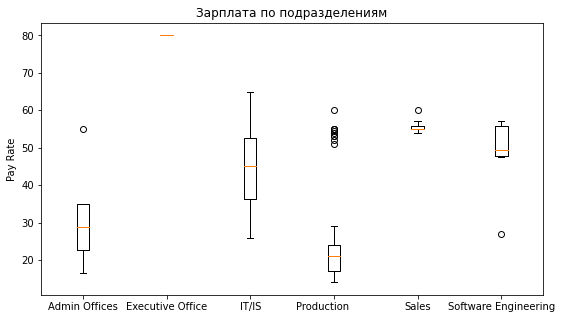

In [ ]:
sql_str = """
SELECT department, hr_dataset."Pay Rate"
FROM hr_dataset
WHERE hr_dataset."Employment Status" = 'Active'
ORDER BY department;
"""
data = postgresql_to_dataframe(sql_str)

plt.figure(figsize=(9,5))
index = 1
for name, group in data.groupby('department'):
    plt.boxplot(group['Pay Rate'], positions=[index], labels=[name])
    index += 1
plt.ylabel('Pay Rate')
plt.title('Зарплата по подразделениям')
plt.show()


**Зависимость зарплаты от расовой принадлежности**

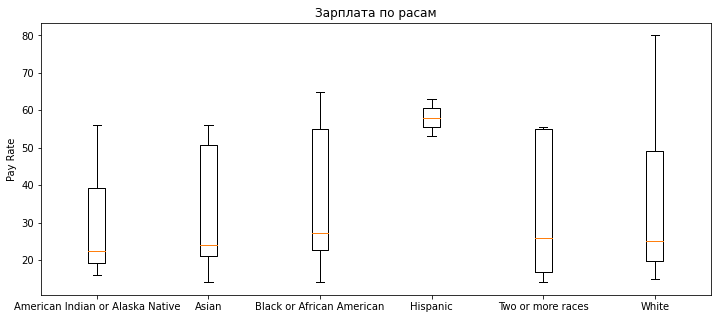

In [ ]:
sql_str = """
SELECT racedesc, hr_dataset."Pay Rate"
FROM hr_dataset
WHERE hr_dataset."Employment Status" = 'Active'
ORDER BY racedesc;
"""
data = postgresql_to_dataframe(sql_str)

plt.figure(figsize=(12,5))
index = 1
for name, group in data.groupby('racedesc'):
    plt.boxplot(group['Pay Rate'], positions=[index], labels=[name])
    index += 1
plt.ylabel('Pay Rate')
plt.title('Зарплата по расам')
plt.show()


### 1.3. Выводы по `hr_dataset`.
Общие данные: 
- *Данные не обезличены*
- **Всего** 183 сотрудников в штате компании на 27 различных позициях.
- По гендерному балансу небольшой перевес в сторону женщин (55.2% vs 44.8%).
- Около 2/3 сотрудников в данный момент не женаты/не замужем.
- Средний возраст сотрудников 38 лет.
- Рассовый состав штата сотрудников неравномерный: 63% белые, 20% черные, 10% азиаты, 5% мулаты, 2% коренные народы, 1% латиноамериканцы, хотя это примерно соответствует расовому составу в США, за исключением латиноамериканцев, которых непропорционально мало в компании.
    ![race ratios](race_ratios_US.png)
- Неграждан США по визе - только один в штате, остальные либо граждане, либо с правом на гражданство.
- Дискриминации в отпате труда по расовому признаку в компании не наблюдается (не принимаем в расчет единственных двух латиноамериканцев в компании - оба оказались на высокооплачиваемых должностях)

Статистика по подразделениям:
- Департамент **Production** самый многочисленный (106 из 183 сотрудников). Соответственно, средняя статистика компании в основном определяется этим подразделением: 59% женщины, 41% мужчины, 77% холосты, средний возраст 38.5. Наименьшая медиана заработной платы в компании.
- **Admin Offices**: 8 сотрудников, в основном женщины (2/3), замужние, средний возраст 32.5.
- **IT/IS**: 35 сотрудников, сбалансированный по полу, 58% в браке, средний возраст 37.4. Средний уровень оплаты труда.
- **Software Engineering**: 7 сотрудников, 72% женщины, 86%  холосты, средний возраст 36.4. Высокий уровень оплаты труда.
- **Sales**: 26 сотрудников, сбалансированный по полу, 70%  холосты, средний возраст 38.5, лучше diversity по рассам, чем в других населенных подразделениях. Высокий уровень оплаты труда.
- **Executive Office**: 1 сотрудник, она же директор.

На основании предоставленного среза базы данных в `hr_dataset` за всё всемя turnover (текучка) оказалась:
- относительно низкой в **Admin Offices, Executive Office, Sales**
- относительно высокой в **IT/IS, Software Engineering**
- самая высокая текучка (количество уволившихся или уволенных составляет 96% от текущего штата сотрудников) в отделе **Production**
- Текучка в группах Asian, Mutli_race и White больше, чем для остальных рас.
- Данный критерий не претендует на объективность текучки кадров, как показатель привлекательности условий труда и/или отношений в коллективе, так как взят за всё время существования компании (среза базы данных)

In [ ]:
## potential mistake in data base: employee terminated but still Active

sql_str = """
SELECT * FROM hr_dataset WHERE (hr_dataset."Date of Termination" IS NOT NULL) AND
(hr_dataset."Employment Status" = 'Active');
"""
postgresql_to_dataframe(sql_str)

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review


Существует одна очевидная ошибка (неверное обновление базы данных) - противоречиные данные (см. строка выше): Estelle Howard уволена 2015-04-15 но до сих пор считается действующим сотрудником. 

Дополнительная гипотеза: Есть зависимость между продолжительностью работы в компании и семейным положением.

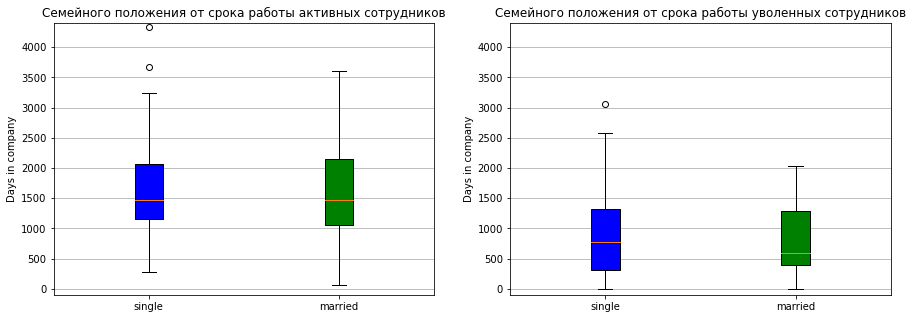

In [ ]:
# подготовка графиков
status = {0 : 'single', 1: 'married'}
color = {0 : 'blue', 1: 'green'}
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# первый график - только действующие сотрудники компании
sql_str = """
SELECT hr_dataset."Days Employed", hr_dataset."marriedid"
FROM hr_dataset
WHERE hr_dataset."Employment Status" = 'Active';
"""
data1 = postgresql_to_dataframe(sql_str)

index = 0
for name, group in data1.groupby('marriedid'):
    bplot = ax1.boxplot(group['Days Employed'], positions=[index], labels=[status[name]], patch_artist=True)
    bplot['boxes'][0].set_facecolor(color[index])
    index += 1
ax1.set_title('Семейного положения от срока работы активных сотрудников')

# второй график - сотрудники, которые уже не работают в компании
sql_str = """
SELECT hr_dataset."Days Employed", hr_dataset."marriedid"
FROM hr_dataset
WHERE hr_dataset."Employment Status" != 'Active';
"""
data2 = postgresql_to_dataframe(sql_str)

index = 0
for name, group in data2.groupby('marriedid'):
    bplot = ax2.boxplot(group['Days Employed'], positions=[index], labels=[status[name]], patch_artist=True)
    bplot['boxes'][0].set_facecolor(color[index])
    index += 1
ax2.set_title('Семейного положения от срока работы уволенных сотрудников')

# настраиваем отображение графиков в одном формате, диапазоне значений.
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Days in company')
    ax.set_ylim([-100, 4400])

plt.show()

Компания достаточно немолодая (кто-то работает уже 10 лет в компании), но медианный срок работы около 3-4 лет. Холостые работают в компании чуть дольше (их и по количеству больше), хотя в недавнем времени компания набирала чуть больше сотрудников в браке, нежели холостых. Оценивая уволивщихся сотрудников, видим, что сотрудники в браке увольнялись чуть быстрее, чем холостые. Большая часть сотрудников уволилась через 1.5-2 года работы.

### 1.3. Анализ `production_staff`.
*Далее анализируем таблицу с самым многочисленным подразделением компании: Production*

In [ ]:
sql_str = """
SELECT * FROM production_staff;
"""

postgresql_to_dataframe(sql_str)

,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,1,"Albert, Michael",White,2011-08-01,None,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
1,2,"Bozzi, Charles",Asian,2013-09-30,2014-08-07,retiring,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
2,3,"Butler, Webster L",White,2016-01-28,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0.0,0.0,0.0,0.0
3,4,"Dunn, Amy",White,2014-09-18,None,N/A - still employed,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
4,5,"Gray, Elijiah",White,2015-06-02,None,N/A - still employed,Active,Production,Production Manager,$54.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
252,253,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
253,254,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
254,255,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN


In [ ]:
# убираем пустые строки и смотрим на активных сотрудников
sql_str = """
SELECT * FROM production_staff WHERE production_staff."Employee Name" IS NOT NULL AND
production_staff."Employment Status" = 'Active';
"""
postgresql_to_dataframe(sql_str) 

,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,1,"Albert, Michael",White,2011-08-01,None,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
1,3,"Butler, Webster L",White,2016-01-28,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0.0,0.0,0.0,0.0
2,4,"Dunn, Amy",White,2014-09-18,None,N/A - still employed,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
3,5,"Gray, Elijiah",White,2015-06-02,None,N/A - still employed,Active,Production,Production Manager,$54.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
4,8,"Liebig, Ketsia",White,2013-09-30,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,201,"Smith, Joe",White,2014-09-29,None,N/A - still employed,Active,Production,Production Technician II,$22.00,Elijiah Gray,Exceeds,12.0,18.0,0.0,0.0
103,202,"Sweetwater, Alex",White,2011-08-15,None,N/A - still employed,Active,Production,Production Technician II,$27.00,Michael Albert,Fully Meets,9.0,10.0,0.0,0.0
104,206,"Walker, Roger",Black or African American,2014-08-18,None,N/A - still employed,Active,Production,Production Technician II,$22.00,Ketsia Liebig,Fully Meets,18.0,17.0,0.0,0.0
105,208,"Wolk, Hang T",White,2014-09-29,None,N/A - still employed,Active,Production,Production Technician II,$22.00,David Stanley,Fully Meets,12.0,17.0,0.0,0.0


Количество сотрудников в подразделении **Production** на одного больше, чем в `hr_dataset`. Найдем этого человека исключительно ради корректировки ошибки в `hr_dataset` или `production_staff`

In [ ]:
sql_str = """
SELECT production_staff.* FROM production_staff WHERE production_staff."Employee Name" IS NOT NULL AND
production_staff."Employment Status" = 'Active' AND
production_staff."Employee Name" NOT IN (SELECT hr_dataset."Employee Name" FROM hr_dataset);
"""
postgresql_to_dataframe(sql_str) 

,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,188,"Monkfish, Erasumus",White,2011-11-07,None,N/A - still employed,Active,Production,Production Technician II,$27.00,David Stanley,Fully Meets,17,18,0,0


**Проанализируем причины увольнения сотрудников и зависимость от руководителя**

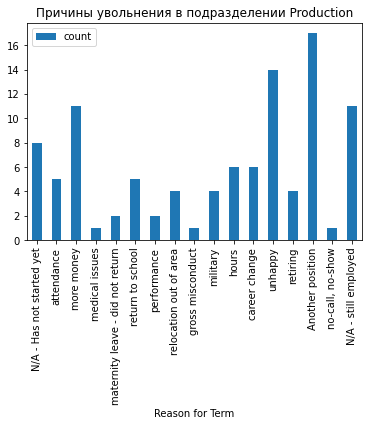

In [ ]:
# Гипотеза: reason of termination per manager
sql_str = """
SELECT production_staff."Reason for Term", count(id)
FROM production_staff
WHERE production_staff."Employment Status" != 'Active'
GROUP BY production_staff."Reason for Term";
"""
# dummy_axes, dummy_plot объявлены исключительно из косметических целей, чтоб убрать вывод __repr__()
dummy_axes = postgresql_to_dataframe(sql_str).set_index('Reason for Term').plot.bar()
dummy_plot = dummy_axes.set_title("Причины увольнения в подразделении Production")

In [ ]:
# 11 сотрудников, c Reason for Term = 'N/A - still employed' находятся на добровольном Leave of Absence по согласованию.
sql_str = """
SELECT production_staff."Employment Status", count(id)
FROM production_staff
WHERE production_staff."Employment Status" != 'Active' AND
      production_staff."Reason for Term" = 'N/A - still employed'
GROUP BY production_staff."Employment Status";
"""
postgresql_to_dataframe(sql_str)

,Employment Status,count
0,Leave of Absence,11


In [ ]:
# проанализируем тех, кто уволен по нарушению трудовой дисциплины, либо недовольные условиями труда
# Reasons: attendance,performance, gross misconduct, unhappy, no-call, no-show.

sql_str = """
SELECT 
    production_staff."Manager Name" as manager_name,
    COUNT(id) filter (WHERE production_staff."Reason for Term" = 'attendance') as attendance,
    COUNT(id) filter (WHERE production_staff."Reason for Term" = 'performance') as performance,
    COUNT(id) filter (WHERE production_staff."Reason for Term" = 'gross misconduct') as gross_misconduct,
    COUNT(id) filter (WHERE production_staff."Reason for Term" = 'unhappy') as unhappy,
    COUNT(id) filter (WHERE production_staff."Reason for Term" = 'no-call, no-show') as no_call_no_show
FROM production_staff
WHERE production_staff."Employment Status" != 'Active' AND 
      production_staff."Reason for Term" != 'N/A - still employed'
GROUP BY production_staff."Manager Name";
"""
postgresql_to_dataframe(sql_str)

,manager_name,attendance,performance,gross_misconduct,unhappy,no_call_no_show
0,Amy Dunn,1,0,0,4,0
1,Brannon Miller,0,0,0,2,0
2,Webster Butler,0,0,0,2,0
3,Michael Albert,1,0,0,1,0
4,Elijiah Gray,0,0,0,1,1
5,David Stanley,0,0,0,1,0
6,Elisa Bramante,1,0,0,1,0
7,Kelley Spirea,1,0,1,0,0
8,Kissy Sullivan,0,2,0,2,0
9,Ketsia Liebig,1,0,0,0,0


Не учитывая, сколько каждый менеджер пробыл на своей должности, можем подвести итог:
- по общей статистике топ 3 причин увольнения: Another position, Unhappy, More money - возможная причина, объединяющая все 3 категории: утомительная работа, недостаточно оплачиваемая, так что люди стремятся сменить должность по возможности либо найти другую работу, считая условия недостаточно справедливыми.
- максимальное количество уволившихся по причите Unhappy у руководителя **Amy Dunn**.
- причина увельнения **Unhappy** самая частая в данной выборке
- по оценке труда уволняла сотрудников только **Kissy Sullivan**
- **David Stanley** и **Ketsia Liebig** уволняли только по одному сотруднику (минимум среди руководителей) - возможно, они показывают лучшее управление персоналом, чем другие уроководители.


**Проанализируем зависимость оценки труда от руководителя**

In [ ]:
# Гипотеза: performance score depends on manager
sql_str = """
SELECT 
    production_staff."Manager Name",
    COUNT(id) filter (WHERE production_staff."Performance Score" = 'Needs Improvement') as "Needs Improvement",
    COUNT(id) filter (WHERE production_staff."Performance Score" = 'Fully Meets') as "Fully Meets",
    COUNT(id) filter (WHERE production_staff."Performance Score" = 'Exceeds') as "Exceeds",
    COUNT(id) filter (WHERE production_staff."Performance Score" = 'Exceptional') as "Exceptional",
    COUNT(id) as "Total Employees"
FROM production_staff
WHERE production_staff."Employment Status" = 'Active'
GROUP BY production_staff."Manager Name";
"""
postgresql_to_dataframe(sql_str)

,Manager Name,Needs Improvement,Fully Meets,Exceeds,Exceptional,Total Employees
0,Amy Dunn,0,3,2,1,8
1,Webster Butler,0,3,1,0,4
2,Brannon Miller,1,6,3,2,13
3,Michael Albert,2,5,1,0,12
4,Elijiah Gray,0,11,2,0,13
5,David Stanley,0,11,0,0,14
6,Elisa Bramante,1,6,2,0,9
7,Kissy Sullivan,0,5,0,1,7
8,Kelley Spirea,0,9,1,0,12
9,Ketsia Liebig,0,11,1,0,15


В целом, явных перекосов (систематической недооценки или переоценки) среди руководителей нет. Тем не менее, стоит отметить руководителей **David Stanley** и **Ketsia Liebig**, у которых практически отсутствуют другие оценки, кроме Fully Meets. **Возможно**, они недостаточно времени отводят процесу оценки performance сотрудников, либо имеют неполное понимание процесса оценки.

**Влияние количества ошибок на оценку труда**

In [ ]:
# Гипотеза: daily error rate vs performance.

sql_str = """
SELECT production_staff."Performance Score", COUNT(id), AVG(production_staff."Daily Error Rate") as Avg_error_rate
FROM production_staff
GROUP BY production_staff."Performance Score"
ORDER BY AVG(production_staff."Daily Error Rate") DESC NULLS LAST;
"""
postgresql_to_dataframe(sql_str)

,Performance Score,count,avg_error_rate
0,Needs Improvement,11,2.0909090909090909
1,90-day meets,18,1.3888888888888889
2,N/A- too early to review,25,1.3200000000000000
3,PIP,7,1.2857142857142857
4,Fully Meets,122,0.72727272727272727273
5,Exceptional,4,0.50000000000000000000
6,Exceeds,22,0.36363636363636363636
7,None,47,None


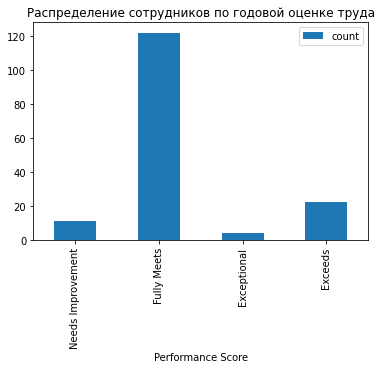

In [ ]:
sql_str = """
SELECT production_staff."Performance Score", COUNT(id)
FROM production_staff
WHERE production_staff."Performance Score" = 'Needs Improvement' OR
      production_staff."Performance Score" = 'Fully Meets' OR
      production_staff."Performance Score" = 'Exceptional' OR
      production_staff."Performance Score" = 'Exceeds'
GROUP BY production_staff."Performance Score"
ORDER BY AVG(production_staff."Daily Error Rate") DESC NULLS LAST;
"""
dummy_axes = postgresql_to_dataframe(sql_str).set_index('Performance Score').plot.bar()
dummy_plot = dummy_axes.set_title('Распределение сотрудников по годовой оценке труда')

Достаточно типичное распределение ежегодных оценок труда (исключаем оценки за неполный период).
Также есть явная пропорциональная зависимость между оценкой и Daily Error Rate. Примечательно, что у людей с оценкой Exceptional количество ошибок даже чуть выше, чем у Exceeds, что говорит, что Error rate не является единственным критерией оценки (что в целом хорошо, так как работа сотрудников оценивается с нескольких точек зрения). 

**Влияние оценки труда на зарплату**

In [ ]:
sql_str = """
SELECT production_staff."Performance Score", COUNT(id), AVG(production_staff."Pay"::numeric::float8) as "Avg pay rate, $"
FROM production_staff
GROUP BY production_staff."Performance Score";
"""
#GROUP BY production_staff."Performance Score";
postgresql_to_dataframe(sql_str)

,Performance Score,count,"Avg pay rate, $"
0,Needs Improvement,11,24.363636
1,None,47,NaN
2,Exceptional,4,22.500000
3,90-day meets,18,21.597222
4,N/A- too early to review,25,21.000000
5,Fully Meets,122,23.248770
6,Exceeds,22,24.015909
7,PIP,7,22.071429


Явной зависимости между Performance score и оплатой труда не наблюдается.

### 1.4. Анализ `recruiting_costs`.

In [ ]:
sql_str = """
SELECT * FROM recruiting_costs;
"""

postgresql_to_dataframe(sql_str)

,id,Employment Source,January,February,March,April,May,June,July,August,September,October,November,December,Total
0,1,Billboard,520,520,520,520,0,0,612,612,729,749,910,500,6192
1,2,Careerbuilder,410,410,410,820,820,410,410,820,820,1230,820,410,7790
2,3,Company Intranet - Partner,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Diversity Job Fair,0,5129,0,0,0,0,0,4892,0,0,0,0,10021
4,5,Employee Referral,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,Glassdoor,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,Information Session,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8,Internet Search,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,MBTA ads,640,640,640,640,640,640,640,1300,1300,1300,1300,1300,10980
9,10,Monster.com,500,500,500,440,500,500,440,500,440,440,500,500,5760


**Проанализируем стоимость найма сотрудников из разных источников**

In [ ]:
sql_str = """
SELECT 
    t."Employee Source",
    t.count,
    t.total_cost,
    t.total_cost / t.count AS "Cost per Employee"
FROM
(
    SELECT
        hr_dataset."Employee Source",
        COUNT(hr_dataset.id),
        MIN(recruiting_costs."Total") as total_cost
    FROM
        hr_dataset LEFT JOIN recruiting_costs ON hr_dataset."Employee Source" = recruiting_costs."Employment Source"
    GROUP BY hr_dataset."Employee Source"
    ORDER BY MIN(recruiting_costs."Total") DESC NULLS LAST
) AS t
ORDER BY t.total_cost / t.count DESC NULLS LAST;
"""
postgresql_to_dataframe(sql_str)

,Employee Source,count,total_cost,Cost per Employee
0,Careerbuilder,1,7790.0,7790.0
1,Pay Per Click,1,1323.0,1323.0
2,MBTA ads,17,10980.0,645.0
3,On-campus Recruiting,12,7500.0,625.0
4,Website Banner Ads,13,7143.0,549.0
5,Social Networks - Facebook Twitter etc,11,5573.0,506.0
6,Newspager/Magazine,18,8291.0,460.0
7,Other,9,3995.0,443.0
8,Billboard,16,6192.0,387.0
9,Diversity Job Fair,29,10021.0,345.0


Сложно проанализировать данные не имея представления об различных истониках набора персонала, но по всей видимости компания достаточно широко диверсифицирует источники и преимущественно пользуется относительно недорогими.

**Рассмотрим зависимость оценки сотрудника от источника найма**

In [ ]:
# Гипотеза: performance score depends on Employment sourse
sql_str = """
SELECT 
hr_dataset."Employee Source", 
COUNT(id) filter (WHERE hr_dataset."Performance Score" = 'Needs Improvement') as "Need Improvement",
COUNT(id) filter (WHERE hr_dataset."Performance Score" = 'Fully Meets') as "Fully Meets",
COUNT(id) filter (WHERE hr_dataset."Performance Score" = 'Exceeds') as "Exceeds",
COUNT(id) filter (WHERE hr_dataset."Performance Score" = 'Exceptional') as "Exceptional"
FROM hr_dataset
GROUP BY hr_dataset."Employee Source";
"""
postgresql_to_dataframe(sql_str)

,Employee Source,Need Improvement,Fully Meets,Exceeds,Exceptional
0,Company Intranet - Partner,0,1,0,0
1,Professional Society,0,9,4,2
2,On-line Web application,0,1,0,0
3,Billboard,1,10,1,1
4,Pay Per Click,0,0,0,0
5,MBTA ads,2,9,3,2
6,Newspager/Magazine,0,10,0,0
7,Search Engine - Google Bing Yahoo,1,19,1,0
8,Pay Per Click - Google,1,12,3,0
9,Internet Search,1,4,0,0


Можно выделить **Professional Society**, **Employee Referral** как относительно успешные способы найма: сотрудники не имеют низшей оценки и сравнительно много Exceeds+ оценок. **Monster.com** и **Diversity Job Fair** достачно противоречивые - есть как выдающиеся сотрудники, так и относительно много отстающих.

### 1.6. Анализ `salary_grid`.

In [ ]:
sql_str = """
SELECT * FROM salary_grid;
"""
postgresql_to_dataframe(sql_str)

,id,Position,Salary Min,Salary Mid,Salary Max,Hourly Min,Hourly Mid,Hourly Max
0,1,Administrative Assistant,30000,40000,50000,14.42,19.23,24.04
1,2,Sr. Administrative Assistant,35000,45000,55000,16.83,21.63,26.44
2,3,Accountant I,42274,51425,62299,20.32,24.72,29.95
3,4,Accountant II,50490,62158,74658,24.27,29.88,35.89
4,5,Sr. Accountant,63264,76988,92454,30.42,37.01,44.45
5,6,Network Engineer,50845,66850,88279,24.44,32.14,42.44
6,7,Sr. Network Engineer,79428,99458,120451,38.19,47.82,57.91
7,8,Database Administrator,50569,68306,93312,24.31,32.84,44.86
8,9,Sr. DBA,92863,116007,139170,44.65,55.77,66.91
9,10,Production Technician I,30000,40000,50000,14.42,19.23,24.04


In [ ]:
## append min/avg/max pay_rate
sql_str = """
SELECT 
    salary_grid."Position",
    salary_grid."Hourly Min",
    salary_grid."Hourly Mid",
    salary_grid."Hourly Max",
    t."Min Pay Rate",
    t."Avg Pay Rate",
    t."Max Pay Rate"
FROM salary_grid LEFT JOIN 
(SELECT
    hr_dataset."position",
    MIN(hr_dataset."Pay Rate"::numeric::float8) as "Min Pay Rate",
    AVG(hr_dataset."Pay Rate"::numeric::float8) as "Avg Pay Rate",
    MAX(hr_dataset."Pay Rate"::numeric::float8) as "Max Pay Rate"
FROM hr_dataset
GROUP BY hr_dataset."position") AS t ON salary_grid."Position" = t."position";
"""
postgresql_to_dataframe(sql_str)

,Position,Hourly Min,Hourly Mid,Hourly Max,Min Pay Rate,Avg Pay Rate,Max Pay Rate
0,Administrative Assistant,14.42,19.23,24.04,16.56,19.520000,21.50
1,Sr. Administrative Assistant,16.83,21.63,26.44,NaN,NaN,NaN
2,Accountant I,20.32,24.72,29.95,23.00,26.833333,29.00
3,Accountant II,24.27,29.88,35.89,NaN,NaN,NaN
4,Sr. Accountant,30.42,37.01,44.45,34.95,34.950000,34.95
5,Network Engineer,24.44,32.14,42.44,27.00,39.677778,49.10
6,Sr. Network Engineer,38.19,47.82,57.91,53.00,54.460000,56.20
7,Database Administrator,24.31,32.84,44.86,30.20,39.476923,48.50
8,Sr. DBA,44.65,55.77,66.91,58.20,60.000000,62.00
9,Production Technician I,14.42,19.23,24.04,14.00,19.104485,24.75


Можно заметить несколько нарушений тарифной сетки, например:
- на должностях **Network Engineer**, **Database Administrator**, **Production Technician II** есть сотрудники, получающие больше максимального оклада для их должностей
- для должности **Production Technician I**	есть сотрудники, получающие меньше и больше тарифной сетки

In [ ]:
close_connection()

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [ ]:
import requests
import time
import pandas as pd
import re
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# запрос-ответ по VK api
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [ ]:
# токен убран из соображения безопасности
vk_token = ''

In [ ]:
url = 'https://api.vk.com/method/account.getProfileInfo?access_token=' + str(vk_token) + '&v=5.92'
response = getjson(url)

try:
    print(list(response['response'].keys())[:3:2], list(response['response'].values())[:3:2])
except Exception as err:
    print(response)

['first_name', 'last_name'] ['Игорь', 'Кучин']


Следующий код подгружает посты со страницы в VK до определенной даты. Коментарии в коде.

Отдельно по хэштэгам:<br>
Учитывая, что тэги на данной стене используются как получится, лишь бы примерно отражало суть поста, не заботясь об использовании заранее определенного формата или набора тэгов, приведем наиболее встречающиеся тэги к одному формату, для более адекватного анализа тэгов, как описания темы/назначения поста:
- всё в нижний регистр
- уберем слово skillbox, так как есть одинаковые тэги #Skillbox_design, #Design_Skillbox 
    - есть даже 2 разных "skillbox" != "skillbох"
- соответственно уберем '_'
- заменим английские слова на аналогичные русские (чтоб статистика 'design' и 'дизайн' суммировалась)
- заменим тэг, где русское слово начинается на английскую 'c': 'cоветпрепода' != 'советпрепода'

In [ ]:
export = pd.DataFrame(columns=['id', 'type', 'date', 'text', 'comments', 'likes', 'reposts', 'views', 
                               'doc', 'link', 'photo', 'poll', 'video', 'tag1', 'tag2', 'tag3', 'number_of_tags', 
                               'poll_votes'])

# vars to pull posts from the wall (VK API)
offset = 0
count = 100
post_date = '2020-07-31' #just to enter the loop for the first time, anything greater than last_date is good to go
last_date = '2019-01-01' # set the date of earliest post

# debugging variable
back_up = []
tag_words_dict = []

# getting ready regular expression for hashtags detection 
reg_expr = r'(?:^|\s)\#(\w+)' # хэш тэг либо в начале новой строки: '^', либо перед white space symbol: '\s' для исключения
                              # подстрок #FF4500 в тексте вроде  "Lush Lava (#FF4500)", либо в адресе ссылки как в строке
                              # "по веб-дизайну: https://vk.com/app6051158_-66669811#sje5Lq"
reg_expr_compiled = re.compile(reg_expr)

# repeat loop up to a specific date: last_date
while post_date > last_date:
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) +\
         f'&owner_id=-66669811&offset={offset}&count={count}&v=5.92'
    response = getjson(url)
    
    # pick information from every post in response
    for post in response['response']['items']:
        
        # mandatory fields
        post_id = post['id']
        post_type = post['post_type']
        post_date = datetime.fromtimestamp(post['date']).strftime('%Y-%m-%d %H:%M:%S')
        post_text = post['text']
        post_comments = post['comments']['count']
        post_likes = post['likes']['count']
        post_reposts = post['reposts']['count']
        post_views = post['views']['count']
        
        # check for last post
        if post_date < last_date:
            break
        
        # optional fields
        
        # ловим хэш-тэги
        # в цикле предполагаем, что хэштэгов может быть несколько, но в таблицу занесем первые 3, 
        # а в датафрейм запишем общее количество хэштегов для отлова постов с бОльшим количеством тэгов
        tags = [None, None, None]
        post_tags = reg_expr_compiled.findall(post_text)
        for i in range(min(3, len(post_tags))):
            
            tags[i] = post_tags[i].lower().replace('skillbox', '')\
                                          .replace('skillbох', '')\
                                          .replace('skillboc', '')\
                                          .replace('_', '')\
                                          .replace('design', 'дизайн')\
                                          .replace('battle', 'баттл')\
                                          .replace('marketing', 'маркетинг')\
                                          .replace('management', 'управление')\
                                          .replace('cоветпрепода', 'советпрепода')
            tag_words_dict.append(post_tags[i].lower().split('_'))
        
        
        # считаем количество attachments по типам
        doc, link, photo, poll, video, poll_votes = 0, 0, 0, 0, 0, 0
        if 'attachments' in post:
            for attachment in post['attachments']:
                att_type = attachment['type']
                if att_type == 'photo':
                    photo += 1
                elif att_type == 'video':
                    video += 1
                elif att_type == 'poll':
                    poll += 1
                    poll_votes += attachment['poll']['votes']
                elif att_type == 'link':
                    link += 1
                elif att_type == 'doc':
                    doc += 1
        
        # выборочно выхватываем пост для детального простомта, если требуется для debugging
        if post_id == 62477: 
            back_up.append(post)
        
        # append post to dataframe
        export = export.append({'id' : post_id, 
                                'type' : post_type, 
                                'date' : post_date, 
                                'text' : post_text, 
                                'comments' : post_comments, 
                                'likes' : post_likes, 
                                'reposts' : post_reposts, 
                                'views' : post_views,  
                                'doc' : doc, 
                                'link' : link, 
                                'photo' : photo, 
                                'poll' : poll, 
                                'video' : video, 
                                'tag1' : tags[0], 
                                'tag2' : tags[1], 
                                'tag3' : tags[2], 
                                'number_of_tags' : len(post_tags), 
                                'poll_votes' : poll_votes}, ignore_index=True)
    
    # update offset for VK API for the next loop
    offset += count
    #time.sleep(0.5) # in case VK will give an error: too much requests per second.

# fix columns type
export = export.astype({'id':'int32', 
                        'date':'datetime64', 
                        'comments':'int32', 
                        'likes':'int32', 
                        'reposts':'int32', 
                        'views':'int32',
                        'doc' : 'int32', '' 
                        'link' : 'int32', 
                        'photo' : 'int32', 
                        'poll' : 'int32', 
                        'video' : 'int32', 
                        'number_of_tags': 'int32',
                        'poll_votes' : 'int32'})

In [ ]:
export['engagement'] = export['likes'] + export['reposts'] + export['comments'] + export['poll_votes']

In [ ]:
export.head(1)

,id,type,date,text,comments,likes,reposts,views,doc,link,photo,poll,video,tag1,tag2,tag3,number_of_tags,poll_votes,engagement
0,86581,post,2020-08-06 13:33:04,Часто видите вакансии по поиску DevOps-инженер...,0,11,0,5502,0,0,7,0,0,взакладки,программирование,None,2,0,11


In [ ]:
# более 3 тэгов не использовалолсь с января 2019
export['number_of_tags'].describe()

count    1374.000000
mean        1.441776
std         0.750257
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: number_of_tags, dtype: float64

**Перейдем к анализу.**

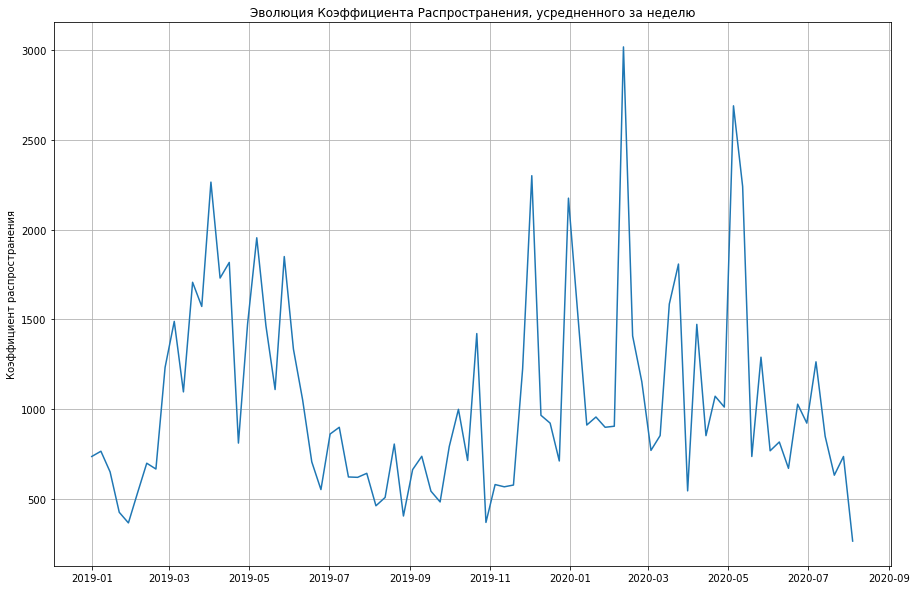

In [ ]:
data = export.groupby(pd.Grouper(key='date', freq='7D')).agg({'engagement':'sum', 'reposts':'sum', 'text':'count'}).copy()

# amplification_rate = N_reposts / N_posts * 100%
data['amplification_rate'] = data['reposts'] / data['text'] * 100

plt.figure(figsize=(15,10))
plt.plot(data['amplification_rate'])
plt.ylabel('Коэффициент распространения')
plt.title('Эволюция Коэффициента Распространения, усредненного за неделю')
plt.grid()
plt.show()

**Посмотрим на количество просмотров и вовлеченность с января 2019 на одном графике**

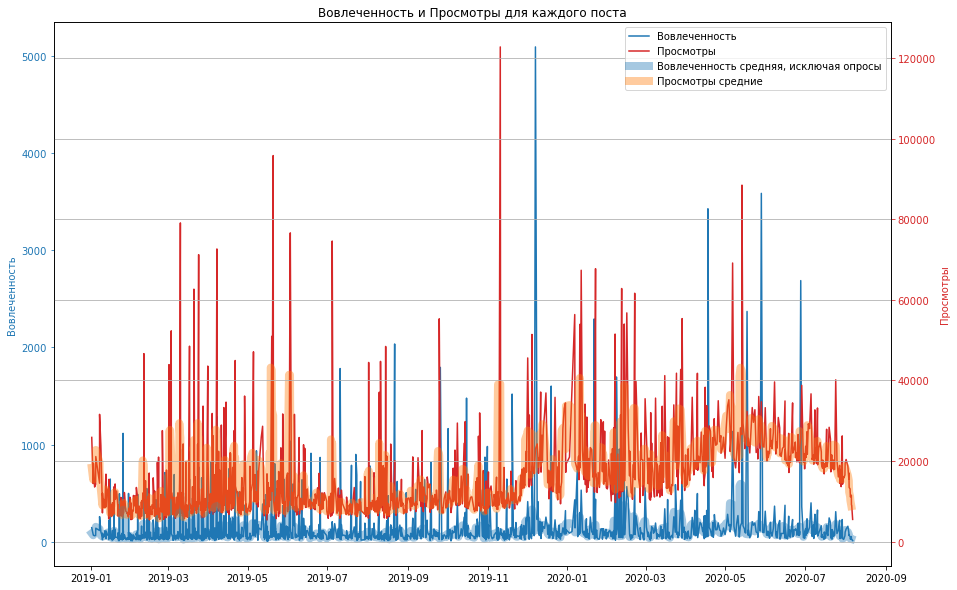

In [ ]:
def plot_combined(export):
    # сделаем график с двумя разными вертикальными осями
    eng_max = export['engagement'].max()
    eng_min = 0
    view_max = export['views'].max()
    view_min = 0

    # определим функции пересчета из одной оси в другую
    def eng2views(engagement):    
        return (engagement - eng_min) / (eng_max + eng_min) * (view_max - view_min) + view_min

    def views2eng(views):
        return (views - view_min) / (view_max + view_min) * (eng_max - eng_min) + eng_min

    # Define a closure function to register as a callback (copy-paste from matplotlib documentation)
    def convert_ax_v_to_view(ax_e):
        y1, y2 = ax_e.get_ylim()
        ax_v.set_ylim(eng2views(y1), eng2views(y2))
        ax_v.figure.canvas.draw()

    fig, ax_e = plt.subplots(figsize=(15,10))
    ax_v = ax_e.twinx()

    # handlers для добавления легенды с именами линий
    handlers = []
    labels = []
    # automatically update ylim of ax2 when ylim of ax1 changes.
    ax_e.callbacks.connect("ylim_changed", convert_ax_v_to_view)

    # все линии рисуем только на ax_e
    # рисуем вовлеченность
    handler, = ax_e.plot(export['date'], export['engagement'], label='Просмотры', color='#1f77b4')
    handlers.append(handler)
    labels.append('Вовлеченность')
    
    # рисуем просмотры
    handler, = ax_e.plot(export['date'], views2eng(export['views']), label='Вовлеченность', color='#d62728')
    handlers.append(handler)
    labels.append('Просмотры')

    # рисуем среднюю вовлеченность по 4 постам
    data = export[export['poll'] == 0]
    handler, = ax_e.plot(data['date'], data['engagement'].rolling(window=4).mean(), 
                         label='Eng_avg', alpha=0.4, linewidth=8)
    handlers.append(handler)
    labels.append('Вовлеченность средняя, исключая опросы')

    # рисуем усредненные просмотры
    handler, = ax_e.plot(export['date'], views2eng(export['views'].rolling(window=4).mean()), alpha=0.4, linewidth=8)
    handlers.append(handler)
    labels.append('Просмотры средние')

    ax_e.set_title('Вовлеченность и Просмотры для каждого поста')
    ax_e.set_ylabel('Вовлеченность')
    ax_v.set_ylabel('Просмотры')

    ax_e.yaxis.label.set_color(handlers[0].get_color())
    ax_e.tick_params(axis='y', colors=handlers[0].get_color())
    ax_v.yaxis.label.set_color(handlers[1].get_color())
    ax_v.tick_params(axis='y', colors=handlers[1].get_color())

    plt.legend(handles=handlers, labels=labels)
    plt.grid()
    plt.show()
    
plot_combined(export)

Можно выделить 3 заметных периода развития VK стены: 
- март-май 2019: высокая вовлеченность, пиковые просмотры, но посетителей, регулярно просматривающих стену не так уж и много, высокий коэфициент распространения.
- июнь-ноябрь 2019: относительно низкая вовлеченность в целом, хотя посты с пиковыми значениями вовлеченности были достаточно частыми, количество регулярной аудитории растет очень медленно, затишье в цитируемости постов.
- декабрь 2019 - настоящее время: вовлеченность обычных постов выросла, количество просмотров всех постов выросла в 2.5 - 3 раза по сравнению с 2019 г, есть рост в цитируемости постов. К настоящему времени количество просмотров падает.

Поскольку надлюдаются 3 вехи развития стены (не без участия общей стратегии компании), для дальнейшего анализа выберем текущий. К тому же данный период достаточно продолжительный для статистики.

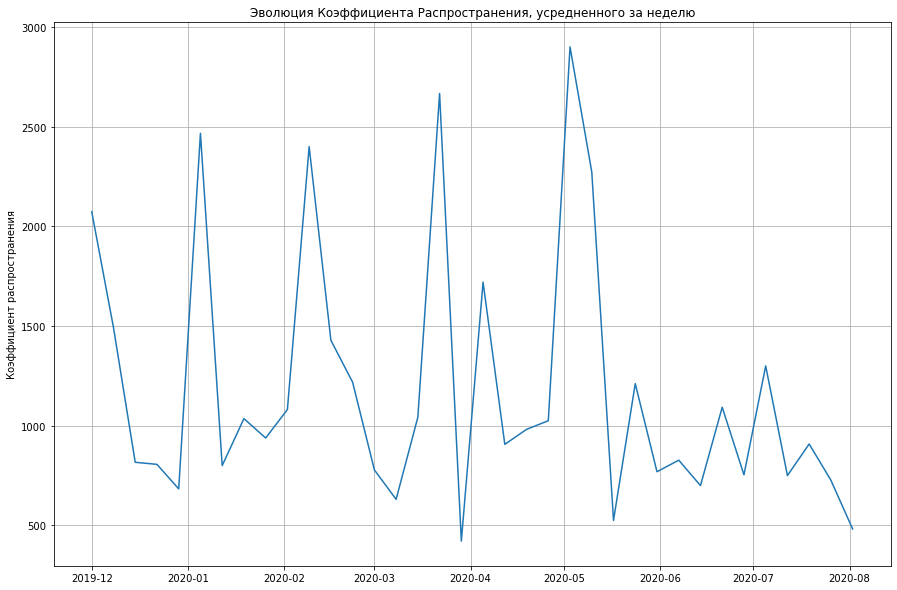

In [ ]:
# отсекаем данные ранее 1-дек-2019.
export = export[export['date'] >= pd.to_datetime('2019-12-01')]

# строим график коэфициента распространения, суммируя репосты за неделю (агрегируя по дате поста, за неимением других данных)
data = export.groupby(pd.Grouper(key='date', freq='7D')).agg({'engagement':'sum', 'reposts':'sum', 'text':'count'}).copy()

# amplification_rate = N_reposts / N_posts * 100%
data['amplification_rate'] = data['reposts'] / data['text'] * 100

plt.figure(figsize=(15,10))
plt.plot(data['amplification_rate'])
plt.ylabel('Коэффициент распространения')
plt.title('Эволюция Коэффициента Распространения, усредненного за неделю')
plt.grid()
plt.show()

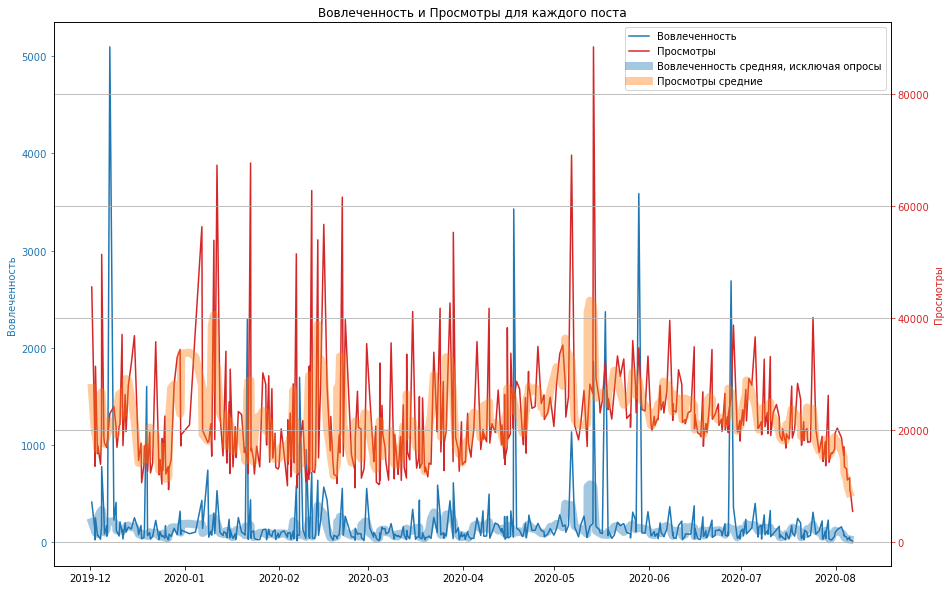

In [ ]:
plot_combined(export)

Из графиков видим, что:
1. самые просматриваемые посты не обязательно выделяются большой вовлеченностью
2. максимумы вовлеченности - это опросы, так как Вовлеченность = коментарии + лайки + репосты + *голоса в голосовании*.
3. По частоте постов с высокими просмотрами (пиковыми по сравнению с другими постами) и коэфициенту распространения SMM отдел работал эффективнее в декабре - апреле, что, вероятно, дало свои плоды в увеличении минимального количества просмотров постов с конца марта до середины июня.
4. Спад количества просмотров в августе по сравнению с июлем вызван тем, что просмотры - интергральная характеристика и чем раньше пост появился, тем больше его посмотрят, даже если аудитория не изменилась. Иными словами, один и тотже пользователь просматривая стену сообщества ежедневно, генерирует по одному просмотрю в день как минимум на последние несколько постов. Вернемся к графику: даже если мы отсечем последнюю неделю, мы всё равно наблюдаем спад минимального количества просмотров с середины июня по середину июля.
5. за последние 3 месяца количество взрывных постов (резко пиковые значения либо просмотров, либо вовлеченности) значительно уменьшилось по сравнению с периодом февраль-апрель.
6. Коэффициент распространения падает с начала года (за исключением нескольких недель ферале и на рубеже апрель-май), что косвенно свидетельствует о ухудшении качества контента (= заинтересованность посетителя в репосте контента)

Общий вывод: намечается тренд на спад аудитории (количество просмотров) и активности (вовлеченности) пользователей в сообществе VK за последние 1-1.5 месяца. Не исключено, что это носит сезонный характер с периодичностью в полгода.

Анализ тегов (тематической наполненности сайта) еще не производился. Промежуточная рекоммендация - написание постов, стимулирующих посетителей делиться информацией и реагировать на нее (активно учавствовать), например: опросы, розыгрышы, анонсы вебинаров и т.п.

*Анализ количеста уникальных посетителей, гостей и просмотров с репоста странички в ВКонтакте по анализу постов стены не возможен.*

Посмотрим на самые успешные посты, вызвавшие наибольший интерес публики.

In [ ]:
# top 5 постов по количеству репоста (бесплатное распространение или релевантность/привлекательность контента)
export.sort_values('reposts', ascending=False).head(5)

,id,type,date,text,comments,likes,reposts,views,doc,link,photo,poll,video,tag1,tag2,tag3,number_of_tags,poll_votes,engagement
162,58762,post,2020-05-06 14:20:16,"Срочно нужна анимация в соцсети, а у дизайнера...",20,935,180,69135,0,0,10,0,0,взакладки,дизайн,None,2,0,1135
152,60637,post,2020-05-13 18:32:38,[club163456906|TEDxDvortsovayaSquare] и Skillb...,802,889,170,88467,0,0,1,0,0,конкурс,ted,None,2,0,1861
437,43555,post,2019-12-04 21:00:01,"Дизайнеры, отвлекитесь от игр со шрифтами. Лов...",5,643,129,51413,0,0,8,0,0,взакладки,дизайн,None,2,0,777
311,50814,post,2020-02-11 14:22:05,"Нужна картинка для соцсетей, а Photoshop нет п...",0,610,109,62806,0,0,6,0,0,взакладки,дизайн,маркетинг,3,0,719
306,51095,post,2020-02-13 13:59:51,"Дизайнеры, собрали для вас сайты, где можно бе...",4,540,93,53996,0,0,7,0,0,дизайн,None,None,1,0,637


интересно, что в **топ 5** вошли посты в феврале и мае 2020 - видимо, SMM работали успешнее (+ один пост с декабря 2019)
- 4 из 5 - Дизайн
- 3 из 5 - В_закладки

In [ ]:
# топ-5 постов по вовлеченности, исключая опросы
export[export['poll'] == 0].sort_values('engagement', ascending=False).head(5)

,id,type,date,text,comments,likes,reposts,views,doc,link,photo,poll,video,tag1,tag2,tag3,number_of_tags,poll_votes,engagement
152,60637,post,2020-05-13 18:32:38,[club163456906|TEDxDvortsovayaSquare] и Skillb...,802,889,170,88467,0,0,1,0,0,конкурс,ted,None,2,0,1861
162,58762,post,2020-05-06 14:20:16,"Срочно нужна анимация в соцсети, а у дизайнера...",20,935,180,69135,0,0,10,0,0,взакладки,дизайн,None,2,0,1135
437,43555,post,2019-12-04 21:00:01,"Дизайнеры, отвлекитесь от игр со шрифтами. Лов...",5,643,129,51413,0,0,8,0,0,взакладки,дизайн,None,2,0,777
311,50814,post,2020-02-11 14:22:05,"Нужна картинка для соцсетей, а Photoshop нет п...",0,610,109,62806,0,0,6,0,0,взакладки,дизайн,маркетинг,3,0,719
306,51095,post,2020-02-13 13:59:51,"Дизайнеры, собрали для вас сайты, где можно бе...",4,540,93,53996,0,0,7,0,0,дизайн,None,None,1,0,637


Топ 5 постов по общей вовлеченности исключая опросы (рассмотрим отдельно): места другие, но участники топа такие же, как в предыдущем топе.

In [ ]:
# топ 10 опросов
export[export['poll'] == 1].sort_values('engagement', ascending=False).head(10)

,id,type,date,text,comments,likes,reposts,views,doc,link,photo,poll,video,tag1,tag2,tag3,number_of_tags,poll_votes,engagement
431,44293,post,2019-12-07 13:00:01,Студия Warner Bros. часто адаптирует свой лого...,89,46,2,22961,0,0,1,1,0,дизайнбаттл,дизайн,None,2,4960,5097
133,66848,post,2020-05-28 14:31:26,О-ОУ!\n\nВозвращаем ваш 2007-ой: вышла обновле...,93,45,2,34704,0,0,1,1,0,дизайнбаттл,дизайн,None,2,3448,3588
187,55791,post,2020-04-17 16:27:29,Один из последних трендов в дизайне — замена о...,30,43,2,25369,0,0,1,1,0,дизайнбаттл,None,None,1,3354,3429
79,78289,post,2020-06-27 19:02:46,"Dolby Labs, ведущая компания в области систем ...",51,42,0,25781,0,0,1,1,0,дизайнбаттл,дизайн,None,2,2596,2689
147,62477,post,2020-05-17 15:40:32,"Друзья, давайте ближе узнаем друг друга — пров...",133,62,0,32327,0,0,1,1,0,вамслово,None,None,1,2176,2371
355,49722,post,2020-01-21 13:01:12,У Xiaomi юбилей — 10 лет! В честь круглой даты...,55,27,1,14993,0,0,1,1,0,дизайнбаттл,дизайн,None,2,2211,2294
318,50689,post,2020-02-07 14:31:03,"Евровидение меняет логотип каждый год, но на э...",30,24,0,17478,0,0,1,1,0,дизайнбаттл,дизайн,None,2,1642,1696
410,47079,post,2019-12-19 14:15:12,Новый год — время перемен. А вот Тинькофф не с...,31,17,0,17521,0,0,1,1,0,дизайнбаттл,дизайн,None,2,1554,1602
315,50772,post,2020-02-09 19:35:10,Выспаться перед работой или посмотреть церемон...,3,18,0,12843,0,0,1,1,0,вамслово,None,None,1,933,954
381,48257,post,2020-01-08 14:10:27,Есть два типа людей:\n «Как же круто я отдохну...,28,26,0,17818,0,0,1,1,0,вамслово,None,None,1,687,741


Топ 10 опросов - по сути список из всех 10 опросов за рассматриваемый период.
- 7 из 10: дизайн_баттл
- остальные 3: вам_слово

Опросы в рубрике #дизайн_баттл в основном проводились в декабре, январе, февраль и мае (по 2 и более). 

Посмотрим на **облако тэгов**

In [ ]:
from wordcloud import WordCloud

In [ ]:
tags_list = export['tag1'].tolist() + export['tag2'].tolist() + export['tag3'].tolist()
print('Количество уникальных тэгов:', len(set(tags_list)))
string_word_cloud = ' '.join(list(filter(None, tags_list))) + ' '

Количество уникальных тэгов: 87


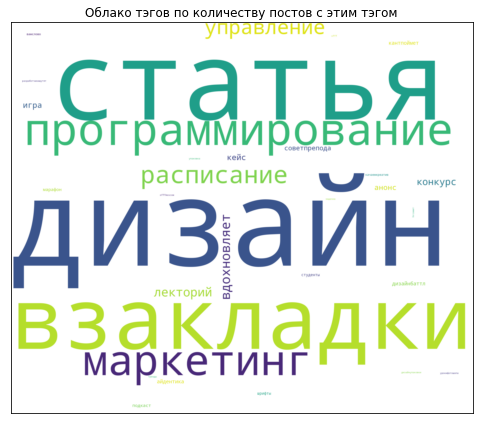

In [ ]:
# для рисования облака тегов
wc = WordCloud(width=2600, height=2200, background_color="white", relative_scaling=1.0,
               collocations=False, min_font_size=10).generate(string_word_cloud)
plt.figure(figsize=(9, 6))
plt.imshow(wc, interpolation="bilinear")
plt.title('Облако тэгов по количеству постов с этим тэгом')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

Наиболее распространенные рубрики (по количеству постов): Дизайн, взакладки, статья, маркетинг, программирование. 

Учитывая, что Skillbox имеет 4 основных направления: дизайн, маркетинг, программирование и управление, делаем вывод, что на странице VK недостаточно внимания уделяется управлению. Скорее всего это связано либо с целевой аудиторией, на которуя нацелена страница в VK, либо с отсутствием привлекательного контента по данной теме.

In [ ]:
# подстчитаем статистику по каждому тегу по месяцам, для определения наиболее вовлекающих/просматриваемых тэгов
agg_dict = {'id' : 'count', 
            'comments' : 'sum', 
            'likes' : 'sum', 
            'reposts' : 'sum', 
            'views' : 'sum', 
            'doc' : 'sum',
            'link' : 'sum', 
            'photo' : 'sum', 
            'poll' : 'sum', 
            'video' : 'sum', 
            'poll_votes' : 'sum', 
            'engagement' : 'sum'}

# создаем таблицу со статистикой по тэгам, группируя по каджому из трех столбцов: tag1, tag2, tag3
data1 = export.groupby(['tag1', pd.Grouper(key='date', freq='M')]).agg(agg_dict)
data1.index.set_names(['tag', 'date'], inplace=True)
data2 = export.groupby(['tag2', pd.Grouper(key='date', freq='M')]).agg(agg_dict)
data2.index.set_names(['tag', 'date'], inplace=True)
data3 = export.groupby(['tag3', pd.Grouper(key='date', freq='M')]).agg(agg_dict)
data3.index.set_names(['tag', 'date'], inplace=True)

# склеиваем тег-дата из результатов группировки по колонкам tag2, tag3
df = data2.merge(data3, how='outer', left_index=True, right_index=True)
df.fillna(0, inplace=True)
columns_list = list(agg_dict.keys())
# суммируем совпадения
for col in columns_list:
    df[col] = df[f'{col}_x'] + df[f'{col}_y']
# убираем ненужные столбцы
for col in columns_list:
    df.drop(columns=[f'{col}_x', f'{col}_y'], inplace=True)

# склеиваем тег-дата из результатов группировки по колонкам tag2+tag3 с tag1
df = df.merge(data1, how='outer', left_index=True, right_index=True)
df.fillna(0, inplace=True)
for col in columns_list:
    df[col] = df[f'{col}_x'] + df[f'{col}_y']
for col in columns_list:
    df.drop(columns=[f'{col}_x', f'{col}_y'], inplace=True)

df.sort_values(['tag', 'date'], inplace=True)

In [ ]:
# создаем датафрейм со статистикой за весь рассматриваемый период
tag_rating = df.reset_index().groupby('tag').sum()
total_engagement = tag_rating['engagement'].sum()
tag_rating['eng_percent'] = tag_rating['engagement'] / total_engagement * 100
# считаем вовлеченность за пост
tag_rating['eng_rate'] = tag_rating['engagement'] / tag_rating['id']
# считаем репосты за пост
tag_rating['amplification_rate'] = tag_rating['reposts'] / tag_rating['id']

# посмотрим на тэги, которые использовались хотя бы 5 раз, считая все остальные разовыми тэгами, с ошибками и прочее
tag_rating[tag_rating['id'] > 4].sort_values('id', ascending=False)
# исследуем данную таблицу чтобы собрать варианты для переименования, например: design -> дизайн, и т.д. (описано выше)

,id,comments,likes,reposts,views,doc,link,photo,poll,video,poll_votes,engagement,eng_percent,eng_rate,amplification_rate
tag,,,,,,,,,,,,,,,
дизайн,113.0,1360.0,15354.0,1725.0,2718591.0,24.0,21.0,435.0,6.0,27.0,16411.0,34850.0,26.043807,308.407080,15.265487
статья,102.0,449.0,6436.0,965.0,1707095.0,0.0,102.0,0.0,0.0,0.0,0.0,7850.0,5.866396,76.960784,9.460784
взакладки,89.0,1075.0,15775.0,2142.0,2579870.0,1.0,1.0,526.0,0.0,10.0,0.0,18992.0,14.192941,213.393258,24.067416
программирование,62.0,653.0,5937.0,695.0,1352366.0,0.0,25.0,173.0,0.0,9.0,0.0,7285.0,5.444165,117.500000,11.209677
маркетинг,59.0,1004.0,6190.0,797.0,1288476.0,4.0,19.0,125.0,0.0,16.0,0.0,7991.0,5.971767,135.440678,13.508475
расписание,34.0,400.0,2006.0,170.0,627227.0,0.0,0.0,34.0,0.0,0.0,0.0,2576.0,1.925075,75.764706,5.000000
управление,28.0,221.0,2992.0,464.0,619328.0,0.0,16.0,75.0,0.0,0.0,0.0,3677.0,2.747865,131.321429,16.571429
вдохновляет,18.0,282.0,2275.0,121.0,415424.0,12.0,0.0,69.0,0.0,10.0,0.0,2678.0,2.001300,148.777778,6.722222
лекторий,17.0,44.0,604.0,45.0,278453.0,0.0,0.0,17.0,0.0,0.0,0.0,693.0,0.517887,40.764706,2.647059


In [ ]:
# топ 10 тэгов по общей вовлеченности
tag_rating.sort_values('engagement', ascending=False).head(10)

,id,comments,likes,reposts,views,doc,link,photo,poll,video,poll_votes,engagement,eng_percent,eng_rate,amplification_rate
tag,,,,,,,,,,,,,,,
дизайн,113.0,1360.0,15354.0,1725.0,2718591.0,24.0,21.0,435.0,6.0,27.0,16411.0,34850.0,26.043807,308.407080,15.265487
дизайнбаттл,7.0,379.0,244.0,7.0,158807.0,0.0,0.0,7.0,7.0,0.0,19765.0,20395.0,15.241419,2913.571429,1.000000
взакладки,89.0,1075.0,15775.0,2142.0,2579870.0,1.0,1.0,526.0,0.0,10.0,0.0,18992.0,14.192941,213.393258,24.067416
маркетинг,59.0,1004.0,6190.0,797.0,1288476.0,4.0,19.0,125.0,0.0,16.0,0.0,7991.0,5.971767,135.440678,13.508475
статья,102.0,449.0,6436.0,965.0,1707095.0,0.0,102.0,0.0,0.0,0.0,0.0,7850.0,5.866396,76.960784,9.460784
программирование,62.0,653.0,5937.0,695.0,1352366.0,0.0,25.0,173.0,0.0,9.0,0.0,7285.0,5.444165,117.500000,11.209677
вамслово,4.0,227.0,132.0,1.0,84961.0,0.0,0.0,4.0,3.0,0.0,3796.0,4156.0,3.105827,1039.000000,0.250000
управление,28.0,221.0,2992.0,464.0,619328.0,0.0,16.0,75.0,0.0,0.0,0.0,3677.0,2.747865,131.321429,16.571429
конкурс,13.0,992.0,1758.0,269.0,282834.0,2.0,0.0,14.0,0.0,1.0,0.0,3019.0,2.256134,232.230769,20.692308


Топ 10 тэгов, собравших максимальное участие аудитории. **дизайнбаттл** и **вамслово** попали в топ исключительно благодаря опросам с этими тэгами. Остальные тэги набрали большое количество коментарий + лайки + репосты.


In [ ]:
# топ 10 тэгов по вовлеченности за пост
tag_rating.sort_values('eng_rate', ascending=False).head(10)

,id,comments,likes,reposts,views,doc,link,photo,poll,video,poll_votes,engagement,eng_percent,eng_rate,amplification_rate
tag,,,,,,,,,,,,,,,
дизайнбаттл,7.0,379.0,244.0,7.0,158807.0,0.0,0.0,7.0,7.0,0.0,19765.0,20395.0,15.241419,2913.571429,1.000000
ted,1.0,802.0,889.0,170.0,88467.0,0.0,0.0,1.0,0.0,0.0,0.0,1861.0,1.390747,1861.000000,170.000000
вамслово,4.0,227.0,132.0,1.0,84961.0,0.0,0.0,4.0,3.0,0.0,3796.0,4156.0,3.105827,1039.000000,0.250000
айдентик,1.0,16.0,393.0,25.0,28021.0,0.0,0.0,9.0,0.0,0.0,0.0,434.0,0.324333,434.000000,25.000000
дизайн,113.0,1360.0,15354.0,1725.0,2718591.0,24.0,21.0,435.0,6.0,27.0,16411.0,34850.0,26.043807,308.407080,15.265487
советпрепода,9.0,58.0,1926.0,306.0,263005.0,0.0,0.0,63.0,0.0,0.0,0.0,2290.0,1.711343,254.444444,34.000000
иллюстрация,2.0,48.0,420.0,32.0,51586.0,0.0,0.0,7.0,0.0,6.0,0.0,500.0,0.373656,250.000000,16.000000
моушен,1.0,7.0,214.0,13.0,29612.0,0.0,0.0,0.0,0.0,1.0,0.0,234.0,0.174871,234.000000,13.000000
конкурс,13.0,992.0,1758.0,269.0,282834.0,2.0,0.0,14.0,0.0,1.0,0.0,3019.0,2.256134,232.230769,20.692308


Посмотрим на показатель вовлеченность/пост для таждого и тэгов (топ 10). 

дизайнбаттл и ted несомненные лидеры (eng_rate). причем один пост **TED** собрал больше коментарий, лайков и репостов (по отдельности и в целом), чем все 7 постов **дизайнбаттл**. По числовым показателям, пост TED был очень успешным. Остальные теги можно оставить на рассмотрение SMM для самостоятельных выводов.

In [ ]:
# топ 10 тэгов по Коэффициенту Распространения
tag_rating.sort_values('amplification_rate', ascending=False).head(10)

,id,comments,likes,reposts,views,doc,link,photo,poll,video,poll_votes,engagement,eng_percent,eng_rate,amplification_rate
tag,,,,,,,,,,,,,,,
ted,1.0,802.0,889.0,170.0,88467.0,0.0,0.0,1.0,0.0,0.0,0.0,1861.0,1.390747,1861.000000,170.000000
советпрепода,9.0,58.0,1926.0,306.0,263005.0,0.0,0.0,63.0,0.0,0.0,0.0,2290.0,1.711343,254.444444,34.000000
,3.0,137.0,465.0,77.0,55152.0,1.0,0.0,2.0,0.0,0.0,0.0,679.0,0.507425,226.333333,25.666667
айдентик,1.0,16.0,393.0,25.0,28021.0,0.0,0.0,9.0,0.0,0.0,0.0,434.0,0.324333,434.000000,25.000000
взакладки,89.0,1075.0,15775.0,2142.0,2579870.0,1.0,1.0,526.0,0.0,10.0,0.0,18992.0,14.192941,213.393258,24.067416
учимhtml,2.0,30.0,362.0,47.0,57823.0,0.0,0.0,10.0,0.0,0.0,0.0,439.0,0.328070,219.500000,23.500000
альпина,2.0,24.0,302.0,45.0,42102.0,0.0,0.0,7.0,0.0,0.0,0.0,371.0,0.277253,185.500000,22.500000
конкурс,13.0,992.0,1758.0,269.0,282834.0,2.0,0.0,14.0,0.0,1.0,0.0,3019.0,2.256134,232.230769,20.692308
геймдизайн,1.0,22.0,170.0,20.0,30497.0,0.0,0.0,9.0,0.0,0.0,0.0,212.0,0.158430,212.000000,20.000000


Посмотрим на показатель Коэффициент Распространения для каждого из тэгов (топ 10).

- Ожидаемо вошел в топ-10 тэг **взакладки** (возможно, это тотже тэг collections, использовавшийся в 2019 году). 
- Хорошо распространяются **советпрепода** и **конкурс**. 
- Остальные тэги в этом топе можно считать разовыми. Однако, я опять отмечу тэг TED, который отличился и в этом рейтинге.

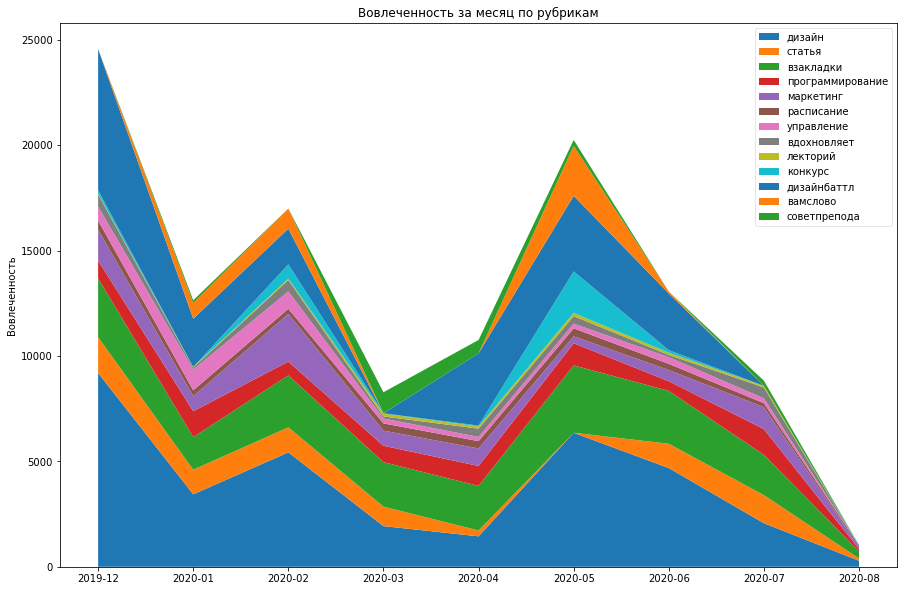

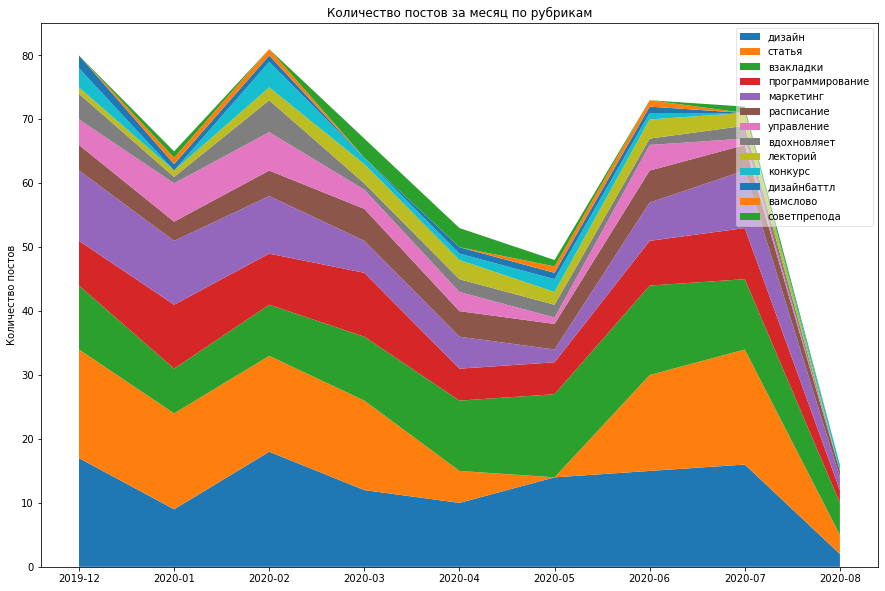

In [ ]:
df = df.reset_index()

def stack_plot_kpi(col_name_kpi, label):
    """
    Рисует stackplot по фиксированному набору тэгов
    col_name_kpi = название колонки из df датафрейма, для вывода на графике
    Например: id (количество постов), comments, likes, reposts, views, doc, link, photo, poll, video, poll_votes, engagement
    label - только для отображения заголовка и оси ординат
    """
    
    stackplot_tags = ['дизайн', 'статья', 'взакладки', 'программирование', 'маркетинг', 'расписание', 'управление', 
                      'вдохновляет', 'лекторий', 'конкурс', 'дизайнбаттл', 'вамслово', 'советпрепода']

    # создаем датафрейм, по которому будем рисовать данные
    stackplot_dates = df.reset_index()['date'].sort_values().unique()
    stack_data = pd.DataFrame({'date' : stackplot_dates})
    # наполняем датафрейм данными: каждый тэг - отдельный столбец
    for tag in stackplot_tags:
        stack_data = stack_data.merge(df[df['tag'] == tag][['date',col_name_kpi]], on='date', how='left')
        stack_data.rename(columns={col_name_kpi : tag}, inplace=True)
    stack_data = stack_data.fillna(0)

    # рисуем графики
    plt.figure(figsize=(15,10))
    plt.stackplot(stack_data['date'].dt.strftime("%Y-%m"), stack_data.drop('date', axis=1).T, labels=stackplot_tags, baseline='zero')
    plt.title(f'{label} за месяц по рубрикам')
    plt.ylabel(label)
    plt.legend(loc='upper right', framealpha=0.5)
    plt.show()
    plt.show()

stack_plot_kpi(col_name_kpi='engagement', label='Вовлеченность')
stack_plot_kpi(col_name_kpi='id', label='Количество постов')

Из графиков видим, что кардинальных изменений в тематическов наполнении стены в рассматриваемый период не было, за некоторыми исключениями, например, **статьи** в мае. Т.о. видим системный подход. В то же время немногочисленные тэги выходят менее регулярно, хоть порой и находят более живой отклик аудитории, например, **дизайнбаттл** и **конкурс** в мае.

*не следует смотреть на сумарный тренд, так как относительно большое количество постов содержат более 1 тэга*

### Выводы.

1. Большая часть аудитории страницы - люди интересующиеся дизайном. Другие направления компании представленны слабее. Это может быть продиктовано как самим vk (больше креативных людей предпочитают что-то узнавать на страничках vk), либо целенаправленно определено руководством компании.
2. За последние несколько месяцев просмотры увеличились почти в 2 раза, что может быть связано как в работой SMM Skillbox в феврале-апреле, так и самоизоляцией и повышенным интересом к онлайн обучению. Несмотря на это, количество постов, которые выстрелили, стало меньше, чем зимой-весной.
3. Тэги используются не системно, т.е. относительно много опечаток, альтернативных названий для одной и той же рубрики. Рекомендация: вести единый реестр тэгов, избегать повторений, использовать его желательно по copy-paste (например во избежание английской 'c' в русском слове). Это позволит проводить аналитику тематического содержания стены более качественно.
4. Возродить рубкики TED, конкурс, которые показывали хорошее вовлечение и цитируемость постов.
5. Рекомендация: поиск креативных идей для привлечения аудитории по другим направлениям компании, отличных от дизайна. Например, для повторения успеха #дизайнбаттл или конкурса TED (если он по итогу был успешным по качеству работ номинантов).